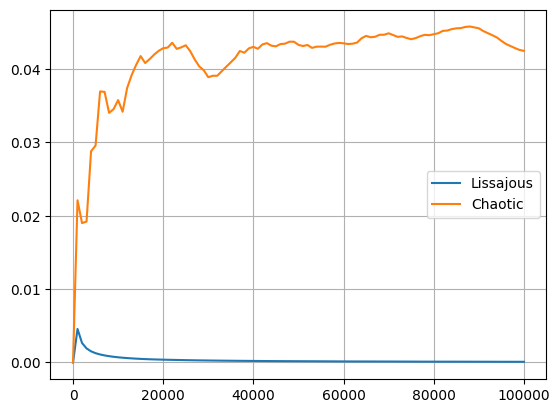

In [5]:
from numiphy.symlib.expressions import *
from numiphy.odesolvers import *
import matplotlib.pyplot as plt

def g(x0):
    return [x0, 0, 0, (2 - 2*Vfunc(x0, 0) - 0**2)**0.5]

t, x, y = variables('t, x, y')
eps = 0.35
a = -Rational(1, 3)

V = x**2/2 + y**2/2 + eps*(x*y**2 + a*x**3)
ch = HamiltonianSystem(V, x, y)

Vfunc = V.lambdify([x, y])
orb1 = ch.new_varorbit(g(0.5))
orb2 = ch.new_varorbit(g(-0.05))

orb1.get(100000, 0.01, rtol=1e-12, atol=0., max_frames=2, split=100, renorm=True)
orb2.get(100000, 0.01, rtol=1e-12, atol=0., max_frames=2, split=100, renorm=True)

t1, ind1 = orb1.lyapunov
t2, ind2 = orb2.lyapunov

fig, ax = plt.subplots()
ax.plot(t1, ind1, label='Lissajous')
ax.plot(t2, ind2, label='Chaotic')
ax.grid(True)
ax.legend()

In [ ]:
from numiphy.symlib.expressions import *
from numiphy.odesolvers import *
import matplotlib.pyplot as plt

t, x, y, px, py = variables('t, x, y, px, py')

symode = SymbolicOde(px, py, -x, -y, symbols=[t, x, y, px, py])
ode_fast = symode.to_lowlevel(stack=True)
ode_mid = symode.to_lowlevel(stack=False)
ode_slow = symode.to_python()
res: dict[LowLevelODE, OdeResult] = {ode_slow: None, ode_mid: None, ode_fast: None}
for ode in res:
    ics = (0, [1.3, -2.4, 3.7, 0.2])
    res[ode] = ode.solve(ics, 500, 0.1, rtol=1e-8, method='RK45')
    print(round(res[ode_slow].runtime / res[ode].runtime, 2), " times faster than the equivalent python code")

#normalized runtimes should be: 1, ~50 , ~150

1.0  times faster than the equivalent python code
52.35  times faster than the equivalent python code
139.87  times faster than the equivalent python code


In [3]:
np.all(res[ode_fast].y == res[ode_slow].y) #should be true. C++ and python implementation of the adaptive RK4 method are identical for numbers of the same precision.

np.True_

In [ ]:
from numiphy.symlib.expressions import *
from numiphy.odesolvers import *
from scipy.integrate import solve_ivp
import time

t, x, y, px, py = variables('t, x, y, px, py')

symode = SymbolicOde(px, py, -x, -y, symbols=[t, x, y, px, py])
ode_fast = symode.to_lowlevel(stack=True)
ode_slow = symode.to_python()
f = symode.codegen().python_callable(ode_style=True)


params = 12*[dict(ics = (0, [1.3, -2.4, 3.7, 0.2]), t=5000, dt=0.1, rtol=1e-6, atol=1e-12, cutoff_step=0., method='RK45', max_frames=0, args=())]

t1 = time.time()
r_fast = ode_fast.solve_all(params, threads=-1)
t2 = time.time()
r_slow = ode_fast.solve_all(params, threads=1)
t3 = time.time()
r_python = ode_slow.solve_all(params, threads=1)
t4 = time.time()
r_scipy = [solve_ivp(f, (0, 5000), [1.3, -2.4, 3.7, 0.2], first_step=0.1, rtol=1e-6, atol=1e-12) for _ in range(12)]
t5 = time.time()

scale = t5-t4
print('Scipy:', 1)
print('Single-threaded Lowlevel python:', scale/(t4-t3))
print('Single-threaded pure lowlevel:', scale/(t3-t2))
print('Multi-threaded pure lowlevel:', scale/(t2-t1))


Compiling ODE...
Done
Scipy: 1
Single-threaded Lowlevel python: 1.8360588538509934
Single-threaded pure lowlevel: 259.53932741911115
Multi-threaded pure lowlevel: 613.6986423722758


In [4]:
from numiphy.symlib.expressions import *

x, y, z = variables('x, y, z')

f = Piecewise((x**2, z<4), (z+y, z<10), (x**5, True))

g = Subs(f, {z:10, x: 4, y:5})

In [5]:
g.eval()

1024